In [25]:
#import paskages
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import VGG16
from keras.layers import *
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
#pip install opencv-python

In [ ]:
#pip install seaborn

In [26]:
# Set directories
train_dir = 'data/Alzheimer_s Dataset/train'
test_dir = 'data/Alzheimer_s Dataset/test'

In [28]:
# # Get class names
# class_names = os.listdir(train_dir)
# Get class names and filter out .DS_Store
class_names = [name for name in os.listdir(train_dir) if name != '.DS_Store']
print(class_names)


['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']


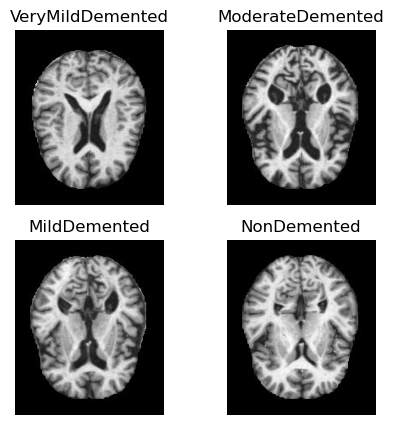

In [29]:
# Print sample images from each class
plt.figure(figsize=(5, 5))
for i, class_name in enumerate(class_names):
    # Get a random image from the class directory
    img_name = np.random.choice(os.listdir(os.path.join(train_dir, class_name)))
    img_path = os.path.join(train_dir, class_name, img_name)
    
    # Read and display the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.show()

In [31]:
# Function to preprocess images
def preprocess_image(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return image, label

In [32]:
# Load image paths and labels
X = []
y = []
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_dir):
        X.append(os.path.join(class_dir, img_name))
        y.append(class_name)

In [33]:
# Split data into training and testing sets while maintaining class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [34]:
# Count number of samples in each class for training and testing sets
train_class_counts = np.unique(y_train, return_counts=True)
test_class_counts = np.unique(y_test, return_counts=True)

In [35]:
# Print the count of each class for training set before upsampling
print("Training Set Class Counts (Before Upsampling):")
for class_name, count in zip(train_class_counts[0], train_class_counts[1]):
    print(f"{class_name}: {count} samples")

Training Set Class Counts (Before Upsampling):
MildDemented: 573 samples
ModerateDemented: 42 samples
NonDemented: 2048 samples
VeryMildDemented: 1433 samples


In [36]:
# Print the count of each class for testing set
print("\nTesting Set Class Counts:")
for class_name, count in zip(test_class_counts[0], test_class_counts[1]):
    print(f"{class_name}: {count} samples")


Testing Set Class Counts:
MildDemented: 144 samples
ModerateDemented: 10 samples
NonDemented: 512 samples
VeryMildDemented: 359 samples


In [37]:
# Function to upsample minority classes
def upsample_minority_classes(X_train, y_train):
    df_train = pd.DataFrame({'image_path': X_train, 'class': y_train})
    class_conts = df_train['class'].value_counts()
    max_class_count = class_counts.max()

    dfs_upsampled = []
    for class_name, count in class_counts.items():
        df_class = df_train[df_train['class'] == class_name]
        if count < max_class_count:
            df_upsampled = resample(df_class, replace=True, n_samples=max_class_count, random_state=42)
            dfs_upsampled.append(df_upsampled)
        else:
            dfs_upsampled.append(df_class)

    df_train_upsampled = pd.concat(dfs_upsampled)
    X_train_upsampled = df_train_upsampled['image_path'].values
    y_train_upsampled = df_train_upsampled['class'].values
    return X_train_upsampled, y_train_upsampled

In [38]:
# Function to upsample minority classes in test data
def upsample_test_minority_classes(X_test, y_test):
    # Combine features and labels into a DataFrame
    df_test = pd.DataFrame({'image_path': X_test, 'label': y_test})

    # Separate majority and minority classes
    df_majority_test = df_test[df_test['label'].isin(['NonDemented'])]
    df_minority1_test = df_test[df_test['label'].isin(['MildDemented'])]
    df_minority2_test = df_test[df_test['label'].isin(['ModerateDemented'])]
    df_minority3_test = df_test[df_test['label'].isin(['VeryMildDemented'])]

    # Upsample minority classes
    df_minority_upsampled1_test = resample(df_minority1_test, replace=True, n_samples=len(df_majority_test), random_state=42)
    df_minority_upsampled2_test = resample(df_minority2_test, replace=True, n_samples=len(df_majority_test), random_state=42)
    df_minority_upsampled3_test = resample(df_minority3_test, replace=True, n_samples=len(df_majority_test), random_state=42)
    
    # Combine majority class with upsampled minority classes
    df_upsampled_test = pd.concat([df_majority_test, df_minority_upsampled1_test, df_minority_upsampled2_test, df_minority_upsampled3_test])

    # Shuffle the dataframe
    df_upsampled_test = df_upsampled_test.sample(frac=1, random_state=42).reset_index(drop=True)

    # Separate features and labels
    X_test_upsampled = df_upsampled_test['image_path'].values
    y_test_upsampled = df_upsampled_test['label'].values

    return X_test_upsampled, y_test_upsampled

In [39]:
# Upsample minority classes in the training set
X_train_upsampled, y_train_upsampled = upsample_minority_classes(X_train, y_train)

In [40]:
# Upsample minority classes in the test set
X_test_upsampled, y_test_upsampled = upsample_test_minority_classes(X_test, y_test)

In [41]:
# Augmented data generator for training
train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.2, 
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest",
                                   rescale=1./255)

In [42]:
# Data generator for testing
test_datagen = ImageDataGenerator(rescale=1./255)

In [43]:
# Training data generator
train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'image_path': X_train_upsampled, 'class': y_train_upsampled}),
    x_col='image_path',
    y_col='class',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 8192 validated image filenames belonging to 4 classes.


In [44]:
# Testing data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_test_upsampled, 'label': y_test_upsampled}),
    directory=None,  
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

Found 2048 validated image filenames belonging to 4 classes.


In [45]:
# After applying ImageDataGenerator, you can check the count of each label
train_label_counts = train_generator.classes
test_label_counts = test_generator.classes

# Count occurrences of each class label
train_label_counts = np.bincount(train_label_counts)
test_label_counts = np.bincount(test_label_counts)

In [46]:
# Print the count of each class for the training set
print("Training Set Class Counts (After Augmentation):")
for i, count in enumerate(train_label_counts):
    print(f"Class {i}: {count} samples")

Training Set Class Counts (After Augmentation):
Class 0: 2048 samples
Class 1: 2048 samples
Class 2: 2048 samples
Class 3: 2048 samples


In [47]:
# Print the count of each class for the testing set
print("\nTesting Set Class Counts:")
for i, count in enumerate(test_label_counts):
    print(f"Class {i}: {count} samples")


Testing Set Class Counts:
Class 0: 512 samples
Class 1: 512 samples
Class 2: 512 samples
Class 3: 512 samples


In [48]:
# Define the model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(4, activation='softmax')
])

In [49]:
# Compile the model
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
   metrics=['accuracy'])

In [50]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath="best_weights.weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)

In [52]:
# Train model
history = model.fit(train_generator , validation_data=test_generator , epochs=50 ,
                    callbacks=[early_stopping,model_checkpoint])

In [ ]:
# Display model summary
model.summary()

In [ ]:
plot_model(model, to_file='model_architecture.png', show_shapes=True)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [ ]:
# Generate predictions
test_predictions = model.predict(test_generator)
predicted_classes = np.argmax(test_predictions, axis=1)

In [ ]:
# True classes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [ ]:
# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [ ]:
# Confusion Matrix
conf_matrix = tf.math.confusion_matrix(labels=true_classes, predictions=predicted_classes)
conf_matrix

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#save model
model.save('alzheimer_detection.h5')